## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
import json

from fabric_cm.credmgr.credmgr_proxy import CredmgrProxy
from fabric_cf.orchestrator.orchestrator_proxy import OrchestratorProxy

credmgr_proxy = CredmgrProxy(credmgr_host=os.environ['FABRIC_CREDMGR_HOST'])
orchestrator_proxy = OrchestratorProxy(orchestrator_host=os.environ['FABRIC_ORCHESTRATOR_HOST'])

In [35]:
#credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
#credmgr_proxy = CredmgrProxy(credmgr_host=credmgr_host)
#orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
#orchestrator_proxy = OrchestratorProxy(orchestrator_host=orchestrator_host)

### Fabric Tokens
Fabric has 2 kinds of tokens:<br>
- Identity : required for Control/Measurement Framework APIs. Identity Token is valid upto an hour.
- Refresh : required to generate new Identity Tokens valid. Refresh Token is valid for 24 hours.

Fabric Identity token is required for Control/Measurement Framework APIs.<br>

When user logins to Jupyterhub after authenticating against CILogon, OIDC refresh token is derived. <br>
This token is available as the environment variable `CILOGON_REFRESH_TOKEN`.<br>

On the first login, we use `CILOGON_REFRESH_TOKEN` to generate new Fabric Identity Token and Fabric Refresh Token.<br>
For any subsequent use, we use Fabric Refresh Token. On every refresh, Fabric Refresh Token is changed and updated.<br>

NOTE: These steps are required for any experiments on Fabric Testbed.<br>

In [2]:
not_found=False
fabric_refresh_token=None
%store -r fabric_refresh_token

#if fabric_refresh_token is None:
#    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
#    %store fabric_refresh_token

if fabric_refresh_token is None:
    %store os.environ['CILOGON_REFRESH_TOKEN']
    
print("Fabric Refresh Token {}".format(fabric_refresh_token))
print("CILOGON_REFRESH_TOKEN environment variable: {}".format(os.environ['CILOGON_REFRESH_TOKEN']))

Fabric Refresh Token https://cilogon.org/oauth2/refreshToken/20c5e1db432d691fc565157595c47d6d/1617284389119
CILOGON_REFRESH_TOKEN environment variable: https://cilogon.org/oauth2/refreshToken/6ba50d63f693184549db8c1b2bae0495/1617207739669


### Get new Fabric Identity Token and update Fabric Refresh Token

Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [3]:
#try:
#    refresh_res = credmgr_proxy.refresh(project_name='all', scope='all', refresh_token=fabric_refresh_token)
#    print("New Tokens received: {}".format(json.dumps(refresh_res)))
#    fabric_id_token=refresh_res['id_token']
#    fabric_refresh_token=refresh_res['refresh_token']
#    print()
#    print("New Refresh Token: {}".format(fabric_refresh_token))
#    print()
#    print("Stored new Refresh Token")
#    %store fabric_refresh_token
#except Exception as e:
#    print("Exception occurred while getting tokens:{}".format(e))
    
    
try:
    refresh_res = credmgr_proxy.refresh(project_name='all', scope='all', refresh_token=fabric_refresh_token)
    #print("New Tokens received: {}".format(json.dumps(refresh_res)))
    fabric_id_token=refresh_res['id_token']
    fabric_refresh_token=refresh_res['refresh_token']
    #print()
    #print("New Refresh Token: {}".format(fabric_refresh_token))
    #print()
    #print("Stored new Refresh Token")
    %store fabric_refresh_token
except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))

Stored 'fabric_refresh_token' (str)


### Orchestrator API example to query for available resources

In [6]:
status, advertised_topology = orchestrator_proxy.resources(token=fabric_id_token)

print(f"Status: {status}")
print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL: { cpu: 6/6, core: 92/96, ram: 1472/1536G, disk: 109100/109600G, unit: 3/3, }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10000/10000G, unit: 10/10, }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 3/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2, }
	Site Interfaces:
RENC: { cpu: 6/6, core: 92/96, ram: 1472/1536G, disk: 109100/109600G, unit: 3/3, }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 1/2, }
		NVME-P4510:  NVME P4510 { disk: 10000/10000G, unit: 10/10, }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
	Site Interfaces:
UKY: { cpu: 6/6, core: 92/96, ram: 1472/1536G, disk: 109100/109600G, unit: 3/3, }
	Co

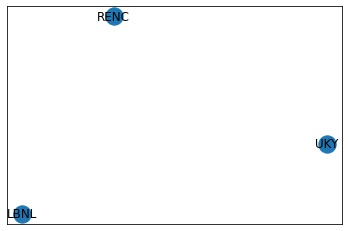

In [7]:
advertised_topology.draw()

## Create Slice

### Simple Node

<img src="./figs/node.png" width="40%"><br>



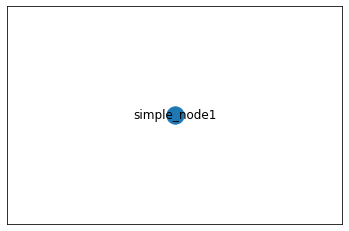

In [12]:
import fim.user as fu

# Create topology
t = fu.ExperimentTopology()

# Set capacities
cap = fu.Capacities()
cap.set_fields(core=4, ram=64, disk=500)

# Add nodes
node1 = t.add_node(name='simple_node1', site='LBNL')
node1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')
node1_nic1 = node1.add_component(ctype=fu.ComponentType.SmartNIC, model='ConnectX-5', name='nic1')


# Generate Slice Graph
#slice_graph = t.serialize()
t.draw()

In [48]:
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read().strip()
    #ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = orchestrator_proxy.create(token=fabric_id_token, slice_name='SimpleNode1', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
print("Reservations created {}".format(reservations))

Response Status Status.FAILURE
Reservations created (500)
Reason: INTERNAL SERVER ERROR
HTTP response headers: HTTPHeaderDict({'Server': 'nginx/1.19.8', 'Date': 'Thu, 01 Apr 2021 14:07:32 GMT', 'Content-Type': 'application/json', 'Content-Length': '35', 'Connection': 'keep-alive'})
HTTP response body: "Slice SimpleNode1 already exists"




In [15]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [38]:
status, slices = orchestrator_proxy.slices(token=fabric_id_token)

print("Response Status {}".format(status))
print("Slices {}".format(slices))

Response Status Status.OK
Slices [{"graph_id": "5ffbd5a4-9776-4946-84d6-e69f4e1c478e", "slice_id": "7466fe43-c6bd-407b-9870-403f866f5d60", "slice_name": "SimpleNode1", "slice_state": "StableOK"}]


## Query Slice

In [39]:
status, slice_obj = orchestrator_proxy.get_slice(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(slice_obj))

Response Status Status.OK
Response received simple_node1[VM]: { core: 4, ram: 64G, disk: 500G, }
Links:


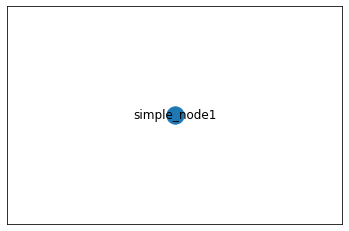

In [40]:
slice_obj.draw()

## Query Slivers

In [41]:
status, reservations = orchestrator_proxy.slivers(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Reservations {}".format(reservations))

Response Status Status.OK
Reservations [{"capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}", "graph_node_id": "45265b77-b1ae-4308-89fd-194c95adbb62", "join_state": "NoJoin", "labels": "", "lease_end": "2021-04-02 12:43:25", "management_ip": "198.129.61.55", "name": "simple_node1", "reservation_id": "d97fd7e7-6cda-40ae-b8c1-454c384eb863", "reservation_state": "Active", "resource_type": "VM", "site": "LBNL", "slice_id": "7466fe43-c6bd-407b-9870-403f866f5d60"}]


In [42]:
# Set the Sliver ID from output of the above command by capturing reservation_id
sliver_id=reservations[0].reservation_id

## Query Sliver

In [44]:
status, reservation = orchestrator_proxy.slivers(token=fabric_id_token, slice_id=slice_id, sliver_id=sliver_id)



print("Response Status {}".format(status))
print("Reservation {}".format(reservation))

print()

MANAGMENT_IP=reservation[0].management_ip
print(MANAGMENT_IP)

Response Status Status.OK
Reservation [{"capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}", "graph_node_id": "45265b77-b1ae-4308-89fd-194c95adbb62", "join_state": "NoJoin", "labels": "", "lease_end": "2021-04-02 12:43:25", "management_ip": "198.129.61.55", "name": "simple_node1", "reservation_id": "d97fd7e7-6cda-40ae-b8c1-454c384eb863", "reservation_state": "Active", "resource_type": "VM", "site": "LBNL", "slice_id": "7466fe43-c6bd-407b-9870-403f866f5d60"}]

198.129.61.55


## Slice Status

In [ ]:
status, slice_status = orchestrator_proxy.slice_status(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Slice Status {}".format(slice_status))

## Sliver Status

In [ ]:
status, reservation_status = orchestrator_proxy.sliver_status(token=fabric_id_token, slice_id=slice_id, sliver_id=sliver_id)

print("Response Status {}".format(status))
print("Reservation Status {}".format(reservation_status))

## Delete Slice

In [49]:
status, result = orchestrator_proxy.delete(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received {'value': None}


## Check out your new node

In [45]:
script= '#!/bin/bash'   '\n' \ 
        'lspci' '\n'

In [1]:
import paramiko 
#from scp import SCPClient, SCPException

key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(MANAGMENT_IP,username='pruth',pkey = key)

stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
print (stdout.read())
print (stderr.read())

client.close()

NameError: name 'MANAGMENT_IP' is not defined